## Importación Código

In [5]:
import pydot
from IPython.display import Image, display, HTML
import queue
import numpy as np
import base64
import heapq

In [6]:
class Node ():
    def __init__(self, state,value,operators, operator=None, parent=None,objective=None):
        self.state= state
        self.value = value
        self.children = []
        self.parent=parent
        self.operator=operator
        self.operators=operators
        self.objective=objective
        self.level=0

    def add_child(self, value, state, operator):
        node=type(self)(value=value, state=state, operator=operator,parent=self, operators=self.operators)
        node.level=node.parent.level+1
        self.children.append(node)
        return node

    def add_node_child(self, node):
        node.level=node.parent.level+1
        self.children.append(node)
        return node

    #Devuelve todos los estados según los operadores aplicados
    def getchildrens(self):
        return [
            self.getState(i)
            if not self.repeatStatePath(self.getState(i))
                else None for i, op in enumerate(operators)]
    
    def heuristic(self):
        value_1 = abs(endState[0] - self.state[0])
        value_2 = abs(endState[1] - self.state[1])
        return value_1 + value_2

    def getState(self, index):
        pass

    def __eq__(self, other):
        return self.state == other.state

    def __lt__(self, other):
        return self.f() < other.f()


    def repeatStatePath(self, state):
        n=self
        while n is not None and n.state!=state:
            n=n.parent
        return n is not None

    def pathObjective(self):
        n=self
        result=[]
        while n is not None:
            result.append(n)
            n=n.parent
        return result

    def printPath(self):
        stack=self.pathObjective()
        while len(stack)!=0:
            node=stack.pop()
            if node.operator is not None:
                print(f'operador:  {operators[node.operator]} \t estado: {node.state}')
            else:
                print(f' {node.state}')

    def cost(self):
        return 1

    def f(self):
        return self.cost()

In [7]:
def draw(root,path):
    graph = pydot.Dot(graph_type='graph')
    nodeGraph=pydot.Node(str(root.state)+"-"+str(0),
                         label=str(root.state),shape ="circle",
                         style="filled", fillcolor="red")
    graph.add_node(nodeGraph)
    path.pop()
    return drawTreeRec(root,nodeGraph,graph,0,path.pop(),path)

def drawTreeRec(root,rootGraph,graph,i,topPath,path):
    if root is not None:
      children=root.children
      for j,child in enumerate(children):
        i=i+1
        color="white"
        if topPath.value==child.value:
          if len(path)>0:topPath=path.pop()
          color='red'
        c=pydot.Node(child.value,label=str(child.state)+r"\n"+r"\n"+"f="+str(child.f()),
                     shape ="circle", style="filled",
                     fillcolor=color)
        graph.add_node(c)
        graph.add_edge(pydot.Edge(rootGraph, c,
                                  label=str(child.operator)+'('+str(child.cost())+')'))
        graph=drawTreeRec(child,c,graph,i,topPath,path)
      return graph
    else:
      return graph

## Ejemplo del mapa de ciudades

Utilizando el ejemplo clásico del mapa de Romania, encontrar el camino más corto de Arad a Bucharest.

Se tiene romania_map, que es la distancia entre cada una de las ciudades adyacentes.

En este problema esta distancia es el costo de los operadores.

Cada nodo tiene tantos operadores como ciudades adyacentes tiene, y el operador es moverse a una nueva ciudad.

El estado de este problema puede definirse como el nombre de la ciudad.

Se tienen las adyacencias entre las ciudades en una variable tipo dict. De esta manera se puede saber cuáles son los próximos operadores válidos, o sea a qué ciudades se puede mover.

In [8]:
romania_map=dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142))

En una estructura como esta para encontrar los adyacentes de una ciudad X no es sólo buscar romania_map[X], porque está puesta la adyacencia una sola vez, por lo que por ejemplo si X='Pitesti' tendría como adyacente a Sibiu, pero además tiene a **Craiova** y a **Bucharest**. A continuación se describe cómo se podría encontar los adyacentes en esta estructura:

In [9]:
state='Pitesti'
keys=[key for key in romania_map]
adj=[]
if state in keys:
  adj=[(key,romania_map[state][key]) for key in romania_map[state]]

cities=[key for key in romania_map]
for c in cities:
  k=[k for k in romania_map[c]]
  if state in k:
    adj.append((c,romania_map[c][state]))
adj
     

[('Rimnicu', 97), ('Bucharest', 101), ('Craiova', 138)]

También se tiene la distancia aérea entre las ciudades y el destino (Bucharest), la cual en este problema es la heurística a seguir.

In [10]:
aerial_distance_Bucharest=dict(
    Arad=366,
    Craiova=160,
    Dobreta=242,
    Eforie=161,
    Fagaras=178,
    Giurgiu=77,
    Hirsora=151,
    Iasi=226,
    Lugoj=224,
    Mehadia=241,
    Neamt=234,
    Oradea=380,
    Pitesti=98,
    Rimnicu=193,
    Sibiu=253,
    Timisoara=329,
    Urziconi=80,
    Vaslui=199,
    Zerind=374)

El estado inicial es la ciudad de donde se parte (Arad) y el estado final la ciudad a donde se quiere llegar (Bucharest)

In [11]:
initState='Arad'
endState='Bucharest'     

Los posibles operadores serían las ciudades en el mapa, en la estructura anterior están todas las ciudades excepto Bucharest. A continuación se extraen las ciudades, se adiciona Bucharest y se ordenan para que estén en orden alfabético.

In [12]:
operators=[op for op in aerial_distance_Bucharest]
operators.append(endState)
operators.sort()

Se define una clase RouteMap para representar el problema de las ciudades.

- Esta clase hereda de Node.
- Tiene dos variables estáticas: mapAdj y distanceA que son el mapa de adyacencias y la distancia entre ciudades respectivamente.
- Se implementa un método para calcular las ciudades adyacentes en cada nodo, a partir del mapa de adyacencias, como se explicó anteriormente.
- Se implementa la función getState donde se define qué operador aplicar, según las ciudades adyacentes calculadas.
- Se implementa la función cost() donde se define que el costo de un nodo es la distancia recorrida desde el nodo inicial hasta él. O sea, cada operador genera como costo la distancia al nodo que genera. El costo es acumulativo, por lo que se va sumando cada una de las distancias recorridas.
- Se implementa heuristic() donde se define la heurística para este problema. En este caso la heurística es la distancia aérea hasta el destino (Bucharest).
La suma del costo y la heurística dará la función f() como ya está definido en la clse Node.

In [13]:
class RouteMap(Node):
  #Definiendo mapa como una variable static
  mapAdj=None
  #Definiendo la distancia aérea como una variable static
  distanceA=None

  def __init__(self,mapAdj=None, distanceA=None, **kwargs):
    super(RouteMap, self).__init__(**kwargs)
    if mapAdj is not None:
        RouteMap.mapAdj = mapAdj
    if distanceA is not None:
        RouteMap.distanceA=distanceA
    self.adj=self.adj()


  def adj(self):
    state=self.state
    keys=[key for key in RouteMap.mapAdj]
    adj=[]
    if state in keys:
      adj=[(key,RouteMap.mapAdj[state][key]) for key in RouteMap.mapAdj[state]]
    cities=[key for key in RouteMap.mapAdj]
    for c in cities:
        k=[k for k in RouteMap.mapAdj[c]]
        if state in k:
          adj.append((c,RouteMap.mapAdj[c][state]))
    result=[a if not self.repeatStatePath(a) else None for a in adj]
    return result

  def getState(self, index):
    if len(self.adj)>0:
        for city,d in self.adj:
            if (self.operators[index]==city):
                return self.operators[index]
    return None

  def cost(self):
    if self.parent is not None:
      #Buscar distancia en adyacentes del padre
      for a in self.parent.adj:
        if a[0]==self.state:
          cost=self.parent.cost()+a[1]
    else:
      cost=0
    return cost

  def heuristic(self):
    if self.state not in RouteMap.distanceA: return 0
    return RouteMap.distanceA[self.state]
     

## Búsqueda Primero a lo Ancho

In [14]:
def breadthFirst(root, startState, endState):
    pq=queue.Queue()
    pq.put(root)
    while not pq.empty():
      node=pq.get()
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), state=child, operator=i)
          pq.put(newChild)
          if endState==child:
            return (root, newChild)

 Arad
operador:  Sibiu 	 estado: Sibiu
operador:  Fagaras 	 estado: Fagaras
operador:  Bucharest 	 estado: Bucharest


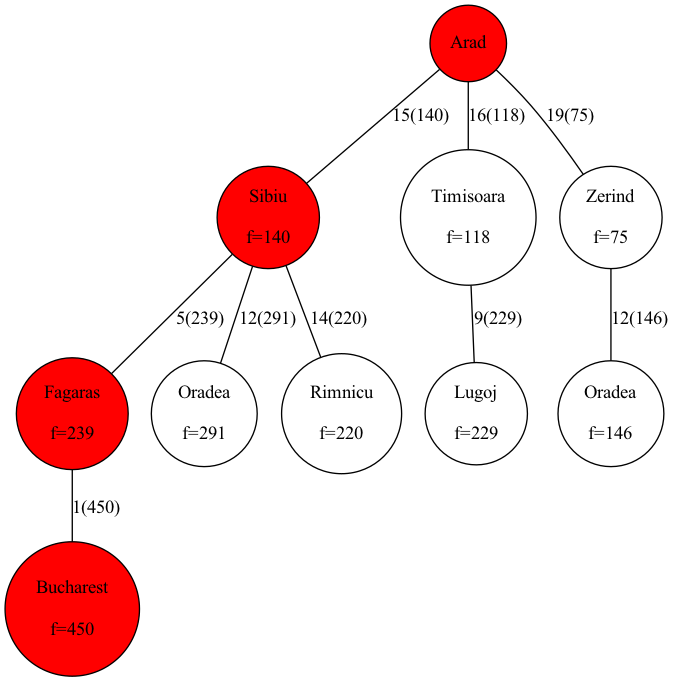

In [15]:
routeAradBucharest=RouteMap(mapAdj=romania_map, distanceA=aerial_distance_Bucharest,value="inicio",state=initState,operators=operators)
(tree, objective)=breadthFirst(routeAradBucharest,initState,endState)
path=objective.pathObjective()
objective.printPath()
graph=draw(tree, path)
tree_image = Image(graph.create_png(), width=600, height=400)
display(tree_image)

## Búsqueda en Profundidad

In [16]:

def dephFirst(root, startState, endState):
    pq=[]
    pq.append(root)
    while len(pq)>0:
      node=pq.pop()
      if (node.parent is not None):
        node.parent.add_node_child(node)
      children=node.getchildrens()
      temp=[]
      for i,child in enumerate(children):
        if child is not None:
          newChild=type(root)(value=node.value+'-'+str(i),state=child, operator=i,
                              parent=node, operators=node.operators)
          temp.append(newChild)
          if endState==child:
            node.add_node_child(newChild)
            return (root, newChild)
      
      temp.reverse()
      for e in temp:
        pq.append(e)

 Arad
operador:  Sibiu 	 estado: Sibiu
operador:  Fagaras 	 estado: Fagaras
operador:  Bucharest 	 estado: Bucharest


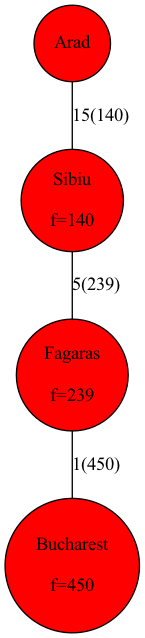

In [17]:
routeAradBucharest=RouteMap(mapAdj=romania_map, distanceA=aerial_distance_Bucharest,value="inicio",state=initState,operators=operators)
(tree, objective)=dephFirst(routeAradBucharest,initState,endState)
path=objective.pathObjective()
objective.printPath()
graph=draw(tree, path)
tree_image = Image(graph.create_png(), width=100, height=300)
display(tree_image)

## Búsqueda Best-First

In [18]:

def bestFirst(root, startState, endState):
    pq=queue.PriorityQueue()
    pq.put((root.heuristic(),root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i),
                                  state=child, operator=i)
          pq.put((newChild.heuristic(),newChild))
          if endState==child:
            return (root, newChild)

 Arad
operador:  Sibiu 	 estado: Sibiu
operador:  Fagaras 	 estado: Fagaras
operador:  Bucharest 	 estado: Bucharest


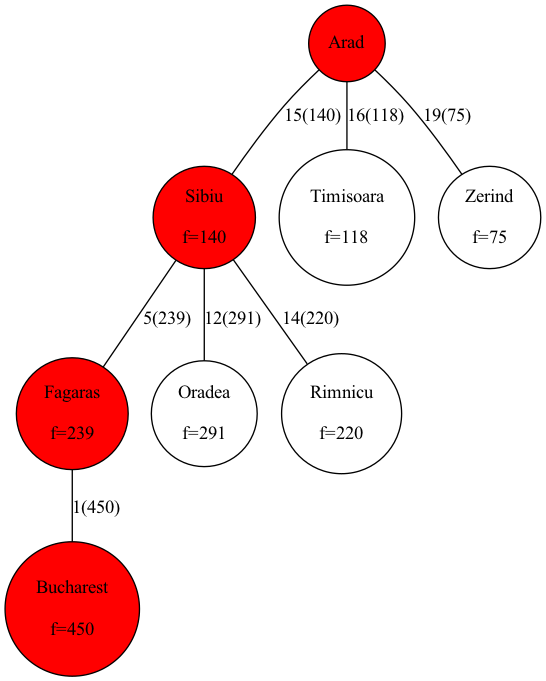

In [20]:
routeAradBucharest=RouteMap(mapAdj=romania_map, distanceA=aerial_distance_Bucharest,value="inicio",state=initState,operators=operators)
(tree, objective)=bestFirst(routeAradBucharest,initState,endState)
path=objective.pathObjective()
objective.printPath()
graph=draw(tree, path)
tree_image = Image(graph.create_png(), width=400, height=400)
display(tree_image)

## Búsqueda A*

In [19]:
def aAsterisk(root, startState, endState):
    pq=queue.PriorityQueue()
    pq.put((root.f(),root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i),
                                  state=child, operator=i)
          pq.put((newChild.f(),newChild))
          if endState==child:
            return (root, newChild)

 Arad
operador:  Sibiu 	 estado: Sibiu
operador:  Fagaras 	 estado: Fagaras
operador:  Bucharest 	 estado: Bucharest


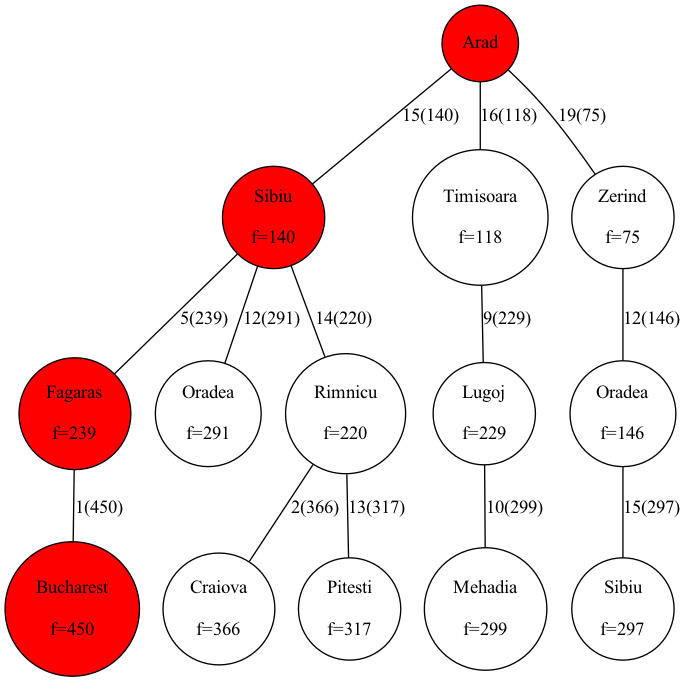

In [21]:
routeAradBucharest=RouteMap(mapAdj=romania_map, distanceA=aerial_distance_Bucharest,value="inicio",state=initState,operators=operators)
(tree, objective)=aAsterisk(routeAradBucharest,initState,endState)
path=objective.pathObjective()
objective.printPath()
graph=draw(tree, path)
tree_image = Image(graph.create_png(), width=500, height=500)
display(tree_image)